# Data Visualization Techniques Demo
This notebook demonstrates a range of data visualization techniques using Matplotlib, Seaborn, and Plotly.
Datasets used: `iris`, `tips`, and `flights` from seaborn.

## Setup: installs and imports
Run the next cell to import libraries. If Plotly is not installed, the cell will install it programmatically.

In [16]:
# Core imports and plotting defaults
import sys
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set styles
%matplotlib inline
sns.set_theme(style="darkgrid", context="notebook")
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 12

# Ensure plotly is available
try:
    import plotly.express as px
except Exception:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'plotly'])
    import plotly.express as px

print('libraries loaded')

libraries loaded


## Load example datasets
We'll load `iris`, `tips`, and `flights` from seaborn and inspect them briefly.

In [17]:
import seaborn as sns
iris = sns.load_dataset('iris')
tips = sns.load_dataset('tips')
flights = sns.load_dataset('flights')

print('iris:', iris.shape)
display(iris.head())
print('tips:', tips.shape)
display(tips.head())
print('flights:', flights.shape)
display(flights.head())

iris: (150, 5)


sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

tips: (244, 7)


total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

flights: (144, 3)


year month  passengers
0  1949   Jan         112
1  1949   Feb         118
2  1949   Mar         132
3  1949   Apr         129
4  1949   May         121

## Line plots & time series (Matplotlib / pandas)
Aggregate the `flights` dataset into a time series and demonstrate line plotting with rolling mean and shaded confidence band.

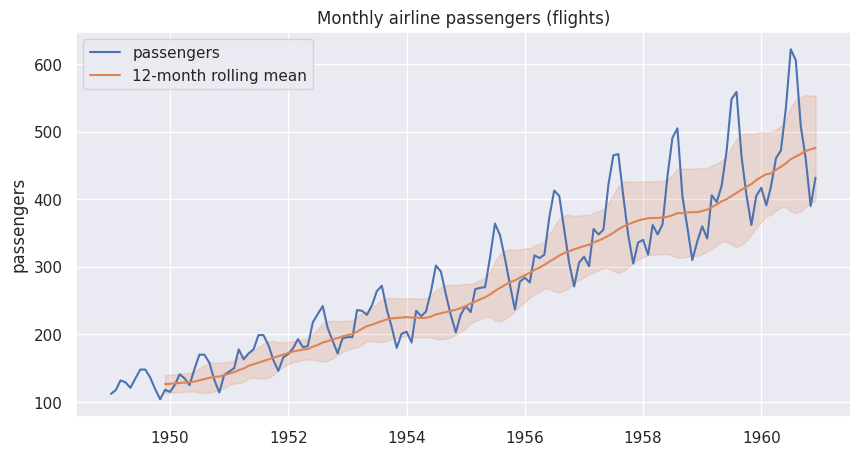

In [31]:
# prepare a datetime index from flights dataset
fl = flights.copy()
fl['month_num'] = pd.to_datetime(fl['month'], format='%b').dt.month
fl['date'] = pd.to_datetime(fl['year'].astype(str) + '-' + fl['month_num'].astype(str).str.zfill(2) + '-01')
ts = fl.set_index('date')['passengers'].sort_index()
ts = ts.asfreq('MS')

# plot with rolling mean and confidence band
fig, ax = plt.subplots()
# convert pandas Index/Series to numpy arrays to satisfy matplotlib type expectations
ax.plot(ts.index.to_numpy(), ts.to_numpy(), label='passengers', color='C0')
rolling = ts.rolling(window=12).mean()
ax.plot(rolling.index.to_numpy(), rolling.to_numpy(), label='12-month rolling mean', color='C1')
# simple band: rolling +/- std (use to_numpy() to avoid ExtensionArray typing issues)
rolling_std = ts.rolling(window=12).std()
lower = (rolling - rolling_std).to_numpy()
upper = (rolling + rolling_std).to_numpy()
ax.fill_between(ts.index.to_numpy(), lower, upper, color='C1', alpha=0.2)
ax.set_title('Monthly airline passengers (flights)')
ax.set_ylabel('passengers')
ax.legend()

## Scatter plots and regression overlays
Scatter plot for `iris` (sepal length vs sepal width) with Seaborn regression overlay.

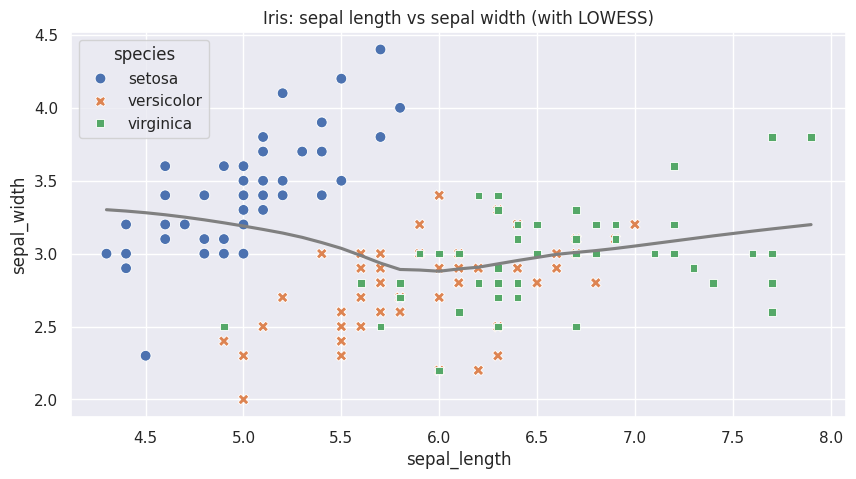

In [19]:
# scatter with seaborn and regression line
fig, ax = plt.subplots()
sns.scatterplot(data=iris, x='sepal_length', y='sepal_width', hue='species', style='species', ax=ax, s=60)
sns.regplot(data=iris, x='sepal_length', y='sepal_width', scatter=False, ax=ax, color='gray', lowess=True)
ax.set_title('Iris: sepal length vs sepal width (with LOWESS)')
ax.legend(title='species')

## Histograms and KDE
Histogram and KDE of `tips.total_bill` comparing density and bins.

Text(0.5, 1.0, 'Distribution of total bill (tips dataset)')

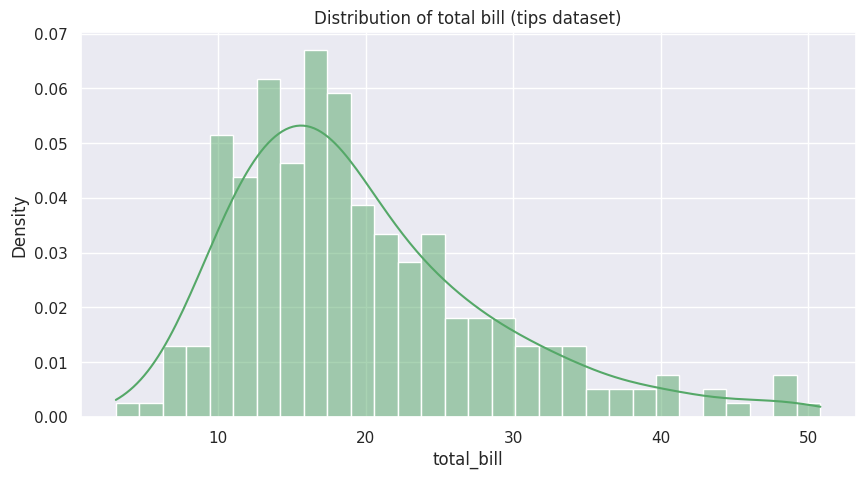

In [32]:
fig, ax = plt.subplots()
# pass the DataFrame via `data=` and specify the column with `x=` to satisfy the type checker
sns.histplot(data=tips, x='total_bill', bins=30, kde=True, stat='density', ax=ax, color='C2')
ax.set_title('Distribution of total bill (tips dataset)')

## Boxplots and violin plots
Boxplot of total bill by day and violinplot with swarm overlay.

Text(0.5, 1.0, 'Violin + swarm: total_bill by day')

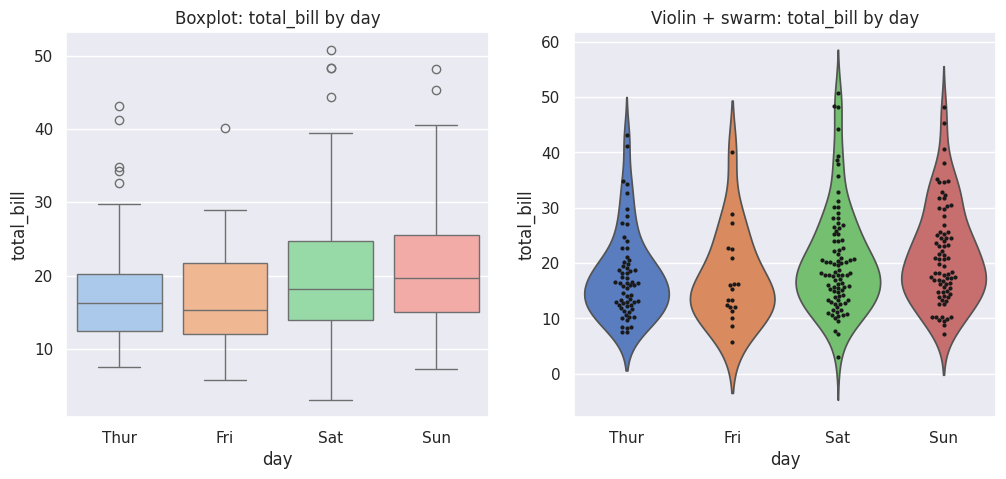

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
# Use `hue`=x and remove the legend to avoid the palette-without-hue deprecation warning
sns.boxplot(data=tips, x='day', y='total_bill', hue='day', dodge=False, ax=axes[0], palette='pastel')
if axes[0].get_legend() is not None:
    axes[0].get_legend().remove()
axes[0].set_title('Boxplot: total_bill by day')
# For violinplot we also pass hue and then remove the generated legend
sns.violinplot(data=tips, x='day', y='total_bill', hue='day', split=False, inner=None, ax=axes[1], palette='muted')
if axes[1].get_legend() is not None:
    axes[1].get_legend().remove()
# overlay the raw points (swarm) as before
sns.swarmplot(data=tips, x='day', y='total_bill', color='k', size=3, ax=axes[1])
axes[1].set_title('Violin + swarm: total_bill by day')

## Heatmap and correlation matrix
Show correlations for the `iris` dataset.

Text(0.5, 1.0, 'Correlation matrix (iris)')

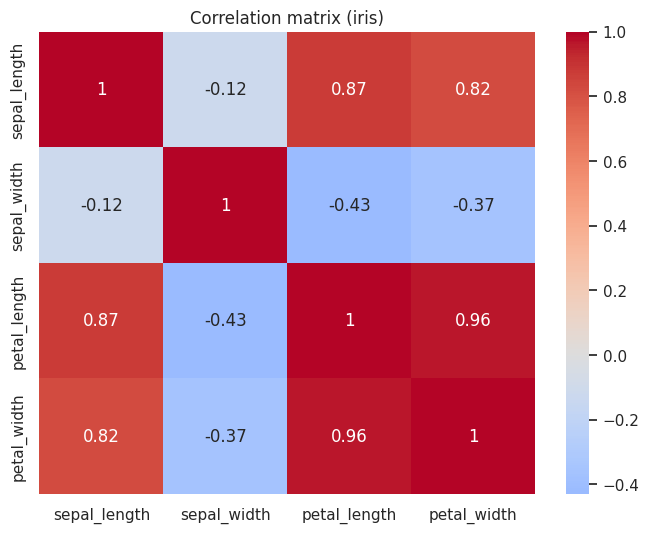

In [22]:
corr = iris.select_dtypes(include=np.number).corr()
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, ax=ax)
ax.set_title('Correlation matrix (iris)')

## Pairplot for multivariate exploration
Pairwise relationships with hue by species. This can be slow on large datasets.

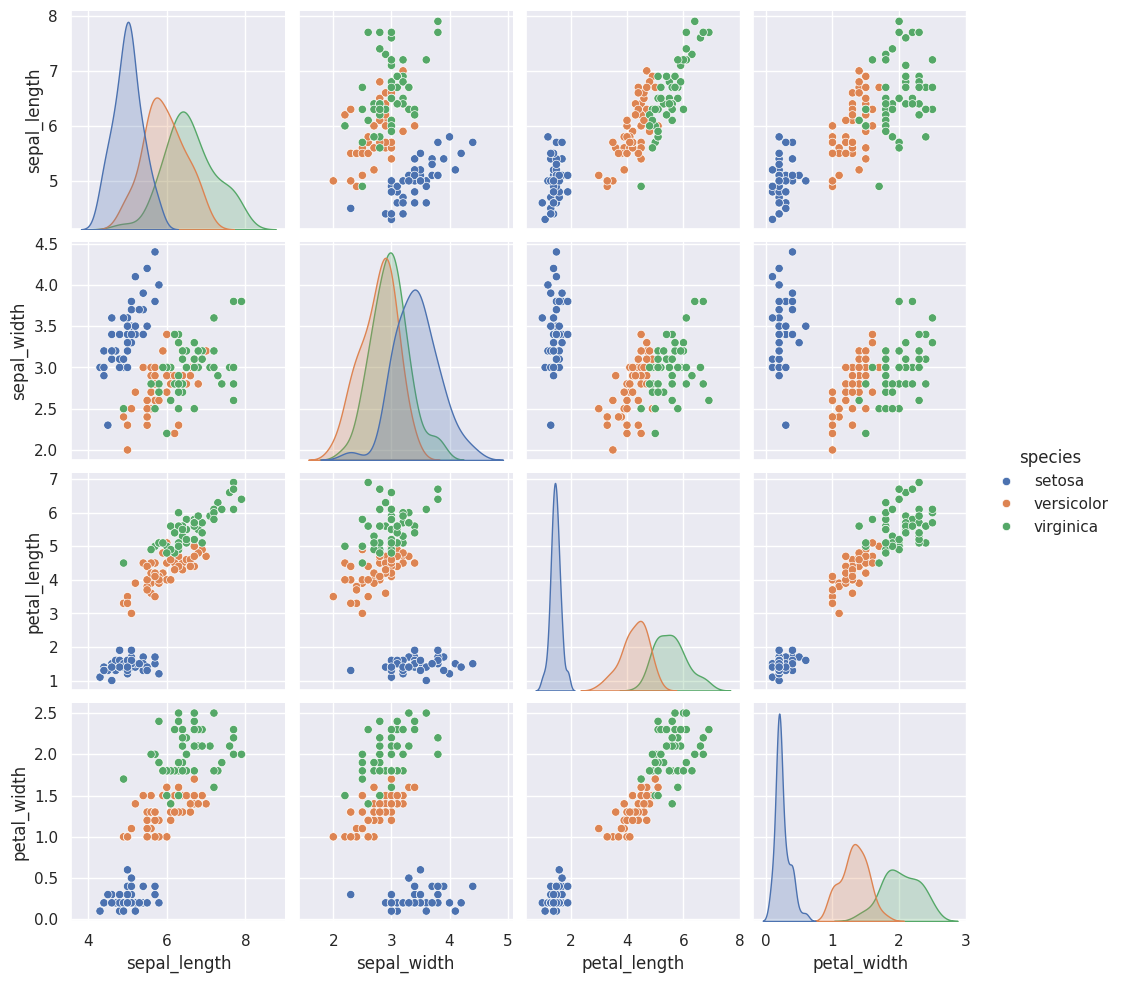

In [23]:
# Pairplot (can take a moment)
sns.pairplot(iris, hue='species', diag_kind='kde', corner=False)

## Interactive plots with Plotly Express
Interactive scatter (tips) and an interactive time series (flights).

In [24]:
import plotly.express as px
from IPython.display import HTML, display
# Create interactive scatter and attempt to show inline; fall back to HTML file if notebook renderer is missing
fig = px.scatter(tips, x='total_bill', y='tip', color='day', hover_data=['sex','size'], title='Tips: total bill vs tip')
try:
    fig.show()
except ValueError as _err:
    fname = 'interactive_tips.html'
    fig.write_html(fname, include_plotlyjs='cdn')
    display(HTML(f'<a href="{fname}" target="_blank">Open interactive_tips.html</a>'))

# interactive time series
ts_df = ts.reset_index().rename(columns={'index':'date', 'passengers':'passengers'})
fig2 = px.line(ts_df, x='date', y='passengers', title='Monthly passengers (interactive)')
try:
    fig2.show()
except ValueError:
    fname2 = 'interactive_flights.html'
    fig2.write_html(fname2, include_plotlyjs='cdn')
    display(HTML(f'<a href="{fname2}" target="_blank">Open interactive_flights.html</a>'))

## Saving figures and exporting
Examples of saving static Matplotlib figures and exporting Plotly to HTML.

saved example_plot.png
saved interactive_tips.html


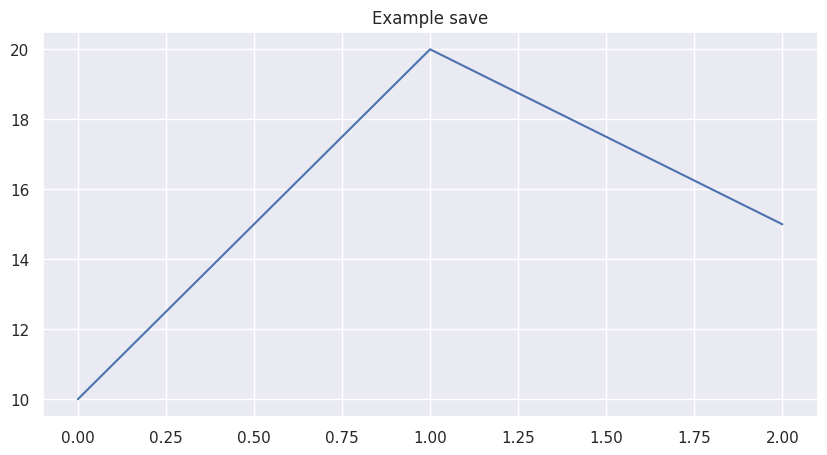

In [25]:
# save last matplotlib figure (if any)
fig_static, ax = plt.subplots()
ax.plot([0,1,2], [10,20,15])
ax.set_title('Example save')
fig_static.savefig('example_plot.png', dpi=150, bbox_inches='tight')
print('saved example_plot.png')

# save plotly to HTML
fig.write_html('interactive_tips.html')
print('saved interactive_tips.html')

## Notes on performance and large datasets
For very large point clouds consider hexbin, datashader, or downsampling. `plt.hexbin` and `sns.kde` are useful for dense plots.

## Datashader example (for very large datasets)
This cell demonstrates how to use `datashader` to render large scatter clouds efficiently. If `datashader` is not installed in your environment the cell will fall back to a Matplotlib `hexbin` plot and print installation instructions.

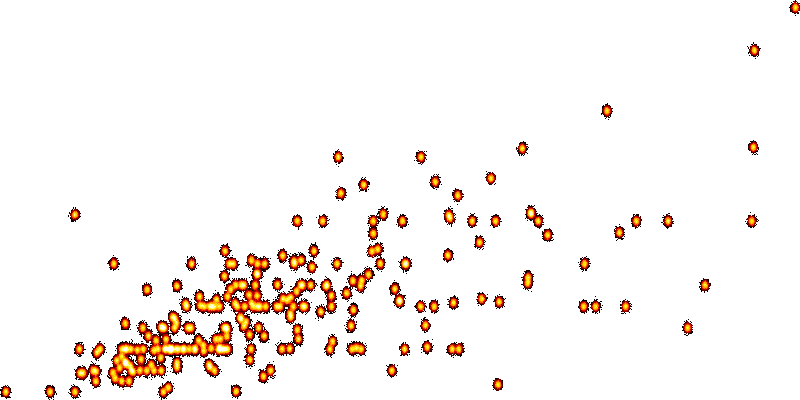

In [26]:
# Datashader example: create a large synthetic point cloud by repeating `tips` and adding jitter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# build a larger dataset by repeating tips several times (adjust multiplier as needed)
mult = 2000  # result ~244 * 2000 ~ 488k rows; reduce if memory is constrained
try:
    big = pd.concat([tips]*mult, ignore_index=True)
except Exception:
    big = tips.sample(frac=1, replace=True).reset_index(drop=True)
# add small jitter so points are not identical
np.random.seed(1)
big['x'] = big['total_bill'] + np.random.normal(0, 0.1, size=len(big))
big['y'] = big['tip'] + np.random.normal(0, 0.05, size=len(big))

# Try to use datashader, otherwise fallback to hexbin
try:
    import datashader as ds
    import datashader.transfer_functions as tf
    import colorcet
    from IPython.display import HTML, display
    # create canvas and aggregate
    cvs = ds.Canvas(plot_width=800, plot_height=400)
    agg = cvs.points(big, 'x', 'y', ds.count())
    img = tf.shade(agg, cmap=colorcet.m_fire, how='eq_hist')
    display(img)
except Exception as e:
    print('datashader not available or failed to render (', e, '). Falling back to matplotlib hexbin.')
    fig, ax = plt.subplots(figsize=(10,4))
    hb = ax.hexbin(big['x'], big['y'], gridsize=80, cmap='viridis')
    fig.colorbar(hb, ax=ax, label='counts')
    ax.set_xlabel('total_bill (jittered)')
    ax.set_ylabel('tip (jittered)')
    ax.set_title('Hexbin fallback (datashader not installed)')
    plt.show()
    print('To enable datashader: pip install datashader colorcet')

## Animated plots (Matplotlib FuncAnimation)
This example creates a simple animated sine wave using Matplotlib's FuncAnimation and displays it inline using HTML/JS. If your environment does not support JS rendering, you can save the animation to MP4/GIF (may require ffmpeg).

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots()
x = np.linspace(0, 2*np.pi, 400)
line, = ax.plot(x, np.sin(x))
ax.set_ylim(-1.5, 1.5)
ax.set_title('Animated sine wave')

def init():
    line.set_ydata(np.sin(x))
    return (line,)

def animate(i):
    line.set_ydata(np.sin(x + i/10.0))
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=30, blit=True)
plt.close(fig)
# Display as JS animation in the notebook (will embed JS/CSS)
HTML(anim.to_jshtml())

In [28]:
# Export the previously-created `anim` to MP4 or GIF.
# This tries MP4 using ffmpeg first, then falls back to GIF via pillow.
from matplotlib import animation as anim_module
out_mp4 = 'sine_animation.mp4'
out_gif = 'sine_animation.gif'
saved = False
# Try MP4 (requires ffmpeg available on PATH)
try:
    Writer = anim_module.writers['ffmpeg']
    writer = Writer(fps=30, metadata=dict(artist='auto'), bitrate=1800)
    anim.save(out_mp4, writer=writer)
    print(f'Saved animation as MP4: {out_mp4}')
    saved = True
except Exception as e:
    print('MP4 export failed or ffmpeg not available:', e)
# Fallback to GIF using pillow writer
if not saved:
    try:
        anim.save(out_gif, writer='pillow', fps=30)
        print(f'Saved animation as GIF: {out_gif}')
        saved = True
    except Exception as e:
        print('GIF export failed:', e)
# Final message with install hints if nothing worked
if not saved:
    print('Unable to save animation. To enable MP4 export install ffmpeg on your system (e.g. apt install ffmpeg) and ensure it is on PATH.')
    print('For GIF export ensure pillow is installed: pip install pillow')

Saved animation as MP4: sine_animation.mp4


## Requirements and how to run
Required Python packages: numpy, pandas, matplotlib, seaborn, plotly, statsmodels. Install with:
`pip install numpy pandas matplotlib seaborn plotly statsmodels`

Recommended quick steps to run locally:
1. Create and activate a virtual environment (recommended):
   `python -m venv .venv`
   On Linux/macOS: `source .venv/bin/activate`
   On Windows (PowerShell): `./.venv/Scripts/Activate.ps1`
2. Install dependencies: `pip install -r requirements.txt` or the pip line above.
3. Start Jupyter: `jupyter lab` or `jupyter notebook` and open this file: `/home/sysadmin/Notebooks/data-visualization-demo.ipynb`.

Notes:
- Plotly inline rendering may raise an error if `nbformat` or notebook MIME renderers are missing; the notebook already falls back to writing interactive HTML files and showing links.
- To export animations to MP4/GIF you may need `ffmpeg` installed on your system.
- For very large datasets consider using datashader (optional) or downsampling before plotting.

## Conclusion and next steps
This notebook provided quick examples across Matplotlib, Seaborn, and Plotly.
Next steps: experiment with custom palettes, GridSpec layouts, animations, or datashader for very large datasets.

To run locally: in a terminal run `jupyter lab` or `jupyter notebook` and open this file: `/home/sysadmin/Notebooks/data-visualization-demo.ipynb`.

## Exporting this notebook to PDF
This section demonstrates how to produce a PDF copy of this notebook programmatically using `nbconvert`. The cell below first attempts a direct PDF export (which commonly requires a LaTeX installation such as TeX Live). If that fails it falls back to exporting an HTML file which you can open in a browser and print/save as PDF.

Note: the code assumes this notebook file is named `data-visualization-demo.ipynb` and is in the current working directory. If your notebook has a different name or path, update the `nb` variable in the code cell.

In [29]:
# Programmatic notebook -> PDF example with fallback to HTML
from pathlib import Path
import subprocess
import sys
import shutil

# Assumption: notebook file is in the current working directory with this name
nb = Path('data-visualization-demo.ipynb')
if not nb.exists():
    print(f'Notebook file not found at {nb.resolve()}. Update the `nb` variable to the correct path.')
else:
    out_pdf = nb.with_suffix('.pdf')

    def run_cmd(cmd):
        print('Running:', ' '.join(cmd))
        res = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        print(res.stdout)
        return res.returncode == 0

    success = False
    # Try jupyter nbconvert (preferred). Note: PDF conversion usually requires LaTeX on the system.
    jupyter = shutil.which('jupyter')
    if jupyter:
        success = run_cmd([jupyter, 'nbconvert', '--to', 'pdf', str(nb)])

    # If direct PDF failed, export to HTML and instruct the user to print to PDF from the browser
    if not success:
        print('Direct PDF export failed or is not available. Falling back to HTML export.')
        html_file = nb.with_suffix('.html')
        # Try nbconvert to HTML (more widely supported)
        if jupyter:
            ok = run_cmd([jupyter, 'nbconvert', '--to', 'html', str(nb)])
        else:
            ok = run_cmd([sys.executable, '-m', 'nbconvert', '--to', 'html', str(nb)])
        if ok:
            print(f'HTML exported to {html_file}. You can open it in a browser and use Print -> Save as PDF (or a headless browser) to create a PDF.')
        else:
            print('HTML export also failed. You may need to install jupyter/nbconvert: pip install jupyter nbconvert')

    else:
        print(f'PDF exported to: {out_pdf.resolve()}')

Running: /home/sysadmin/Projects/data-visualization-demo/.venv/bin/jupyter nbconvert --to pdf data-visualization-demo.ipynb
[NbConvertApp] Converting notebook data-visualization-demo.ipynb to pdf
/home/sysadmin/Projects/data-visualization-demo/.venv/share/jupyter/nbconvert/templates/latex/display_priority.j2:32: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.plotly.v1+json']) is not able to be represented.
  ((*- endblock -*))
[NbConvertApp] Support files will be in data-visualization-demo_files/
[NbConvertApp] Making directory ./data-visualization-demo_files
[NbConvertApp] Writing 77240 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 668080 bytes to data-visualization-demo

### Notes and alternatives
- Direct PDF export via `nbconvert --to pdf` typically uses a LaTeX intermediate; installing a TeX distribution (TeX Live on Linux) is often required: e.g., `sudo apt install texlive-xetex texlive-fonts-recommended texlive-latex-recommended`.
- If you prefer not to install LaTeX, export to HTML (`nbconvert --to html`) and then: open in a browser and Print -> Save as PDF, or use a headless browser (Chromium/Chrome) to print-to-pdf programmatically (e.g., Puppeteer/Playwright).
- Example command-line alternative (if you have chromium):
  `chromium --headless --disable-gpu --print-to-pdf=output.pdf data-visualization-demo.html`
- If you want, I can also add an automated Chromium-based HTML->PDF step (requires installing Chromium) or a Playwright/Pyppeteer example—tell me which fallback you'd prefer.

## Automated Chromium HTML -> PDF (optional)
The cell below will look for a Chromium/Chrome binary on your PATH and, if found, will run it in headless mode to convert the previously-exported HTML (`data-visualization-demo.html`) to a PDF. This is useful when LaTeX is not installed and you want a fully automated HTML->PDF step.

If you don't have Chromium/Chrome installed, the cell will print install suggestions for common Linux distributions.

In [30]:
# Automated Chromium/Chrome HTML -> PDF converter
from pathlib import Path
import shutil
import subprocess
import sys

nb = Path('data-visualization-demo.ipynb')
html = nb.with_suffix('.html')
out_pdf = nb.with_suffix('.chromium.pdf')

if not html.exists():
    print(f'HTML file not found at {html.resolve()}. Run the HTML export step first (nbconvert to html) or re-run the previous cell that exports HTML.')
else:
    # Common executable names for chromium/google-chrome
    candidates = ['chromium', 'chromium-browser', 'chromium-stable', 'google-chrome', 'google-chrome-stable', 'chrome']
    exe = None
    for c in candidates:
        path = shutil.which(c)
        if path:
            exe = path
            break

    if not exe:
        print('No Chromium/Chrome executable found on PATH.')
        print('Install suggestions (Debian/Ubuntu): sudo apt install chromium-browser')
        print('Or on Debian/Ubuntu to get a recent Chrome: install google-chrome-stable from Google repository.')
    else:
        # Use an absolute path to the HTML file
        html_path = str(html.resolve())
        pdf_path = str(out_pdf.resolve())
        cmd = [exe, '--headless', '--no-sandbox', '--disable-gpu', f'--print-to-pdf={pdf_path}', html_path]
        print('Running:', ' '.join(cmd))
        res = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        print(res.stdout)
        if res.returncode == 0 and Path(pdf_path).exists():
            print(f'Chromium produced PDF: {pdf_path}')
        else:
            print('Chromium print-to-pdf failed. Review the output above. As an alternative, open the HTML in a browser and use Print -> Save as PDF.')

Running: /snap/bin/chromium --headless --no-sandbox --disable-gpu --print-to-pdf=/home/sysadmin/Projects/data-visualization-demo/data-visualization-demo.chromium.pdf /home/sysadmin/Projects/data-visualization-demo/data-visualization-demo.html
[24320:24320:1112/184948.008100:ERROR:dbus/object_proxy.cc:573] Failed to call method: org.freedesktop.DBus.Properties.GetAll: object_path= /org/freedesktop/UPower/devices/DisplayDevice: org.freedesktop.DBus.Error.ServiceUnknown: The name org.freedesktop.UPower was not provided by any .service files
1125049 bytes written to file /home/sysadmin/Projects/data-visualization-demo/data-visualization-demo.chromium.pdf

Chromium produced PDF: /home/sysadmin/Projects/data-visualization-demo/data-visualization-demo.chromium.pdf
